In [1]:
import pickle
import numpy as np
from re import split

## create a dataset with a 'cluster' field

In [2]:
data = pickle.load(open("data/emotype_v10.p", "rb" ))

label_cluster_dict = {'addiction':0, 'anxiety':1, 'autism':2, 
                         'bipolar':3, 'conversation':4, 'depression':5, 
                         'happy':6, 'schizophrenia':7}

def initialize_cluster(data_dict, label_cluster_dict):
    """Initialize dictionary of OPs with cluster labels according original topic. """
    for i in range(len(data_dict)):
        data_dict[i]['cluster'] = label_cluster_dict[data_dict[i]['label']]
    return data_dict

data = initialize_cluster(data, label_cluster_dict)

## TFIDF
#### short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document/class in a collection or corpus (many classes/documents). Here we use the class interchangeably with document. 

### First, TF and IDF are measured for a single word

#### TF = term requency 

$$ TF_w = \frac{\text{word count in class}}{\text{total word count in that class including repeats}} $$

#### IDF = inverse document frequency

$$ IDF_w = \log{\frac{\text{number of classes}}{\text{total number of classes tha word appears in} + \epsilon}} $$

### then TF is multiplied with IDF

$$ TFIDF_w = TF_w \cdot IDF_w $$

In [3]:
class tfidf():
    
    def __init__(self, data, label_cluster_dict):
        
        self.data = data  # Dictionary with keys corresponding to OPs (values are also dicts)
        self.tfidf_mat = None
        self.word_freq_mat = None
        self.count_dict = initialize_count_dict(data)
        self.word_list = list(self.count_dict.keys())
        self.word_list = list(dic.keys())
    
    def phrase_to_tokens(phrase):
        """Takes in a (str) phrase and turns it into standardized tokens 
        """
        phrase = phrase.strip()
        phrase = phrase.lower()
        phrase = phrase.replace("'", "")  # Get rid of apostrophes
        list_of_words_in_phrase = split("[^a-zA-Z]+", phrase)  # split phrase into words/tokens
        return list_of_words_in_phrase
        
    def initialize_count_dict(self, data):
        """ Returns a dictionary with 
        """
        lexicon = set()
        for i in range(len(data)):  # For every phrase in our data
            ith_phrase = data[i]['text']  # Get text from ith phrase 
            list_of_words_in_phrase = phrase_to_tokens(ith_phrase)
            lexicon.update(list_of_words_in_phrase)  # Add all of the text's words to lexicon
            count_dict = {}.fromkeys(lexicon, 0)  # Create an empty dictionary from the set of words
        return count_dict
        
    def find_text_with_cluster(self, cluster_idx):
        '''input: class index (integer)
           output: list of phrases where each phrase is itself a list of word strings'''
        str_list = []
        for i in range(len(data)):
            if data[i]['cluster'] == cluster_idx:
                str_list.append(split("[^a-zA-Z']+", data[i]['text'].strip().lower() ))
        return str_list
    
    def count_word_of_cluster(self, str_list):
        '''returns a dictionary of counts for each word in the vocabulary'''
        # self.count_dict = dict.fromkeys(self.dic, 0) # make a copy of dic, prefilled wi 0 count
        for phrase in str_list:
            for word in phrase:
                if word: self.count_dict[word] += 1 # if string is not empty,'', increment count

    def get_cluster_vectors(self, word_list, count_dic):
        '''input: list of strings and dictionary of word counts
           output: vector of integers representing counts for each word in wordlist'''
        out = []
        for word in word_list:
            out.append(self.count_dict[word])
        return out

    def extract_vectors(self, cluster):
        text_cluster = self.find_text_with_cluster(cluster)
        dic_cluster = self.count_word_of_cluster(text_cluster)
        vector_cluster = self.get_cluster_vectors(self.word_list, dic_cluster)
        return vector_cluster
    
    def make_tfidf_mat(self):
    
        num_clusters = len(label_cluster_dict)  
        num_words_in_lexicon = len(self.word_list)

        # Rows are clusters, columns are words, and elements are word frequencies in the cluster
        self.word_freq_mat = np.zeros((num_clusters, num_words_in_lexicon))  # < number of classes, vocab size >

        for cluster_name, cluster_label in label_cluster_dict.items():
            cluster_freqs = np.array(self.extract_vectors(cluster_label))
            self.word_freq_mat[cluster_label, :] = cluster_freqs

        # a matrix where each element is the term frequency for the word of the same index 
        # the count is divided by the sum over the row, TF = the word_count/total_word_count

        term_frequency = self.word_freq_mat / np.sum(self.word_freq_mat, axis=1, keepdims=True)

        # axis = 1 means you sum across the row and you are left with a column

        epsilon = 0.0001 # smoothing constant 
        # a vector of size vocab_size, where each element is the number of clusters/docs/classes 
        # that has greater than 0 instances of the word that has the same index as that element 

        num_clusters_with_word_present = np.sum(self.word_freq_mat > 0, axis=0, keepdims=True)

        # num_clusters_with_word_present.shape # (1, vocab_size)

        idf = np.log(num_clusters / (num_clusters_with_word_present + epsilon))

        self.tfidf_mat = term_frequency * idf 

        # tfidf.shape = (num_classes, vocab_size)
    
    def get_top_n_tfidf(self, n, cluster_idx):
        if self.tfidf_mat is None:   # if we haven't initialized our tf-idf matrix yet...
            print(" calculating tfidf...")
            self.make_tfidf_mat()  # ...then make it when the user asks for a specific label
        top_n_tfidf = np.argsort(self.tfidf_mat, axis=1)[:, -n:]
        return [self.word_list[i] for i in list(top_n_tfidf[cluster_idx, :])]

In [4]:
tfidf_data = tfidf(data, label_cluster_dict)

NameError: name 'initialize_count_dict' is not defined

In [5]:
tfidf_data.word_freq_mat

NameError: name 'tfidf_data' is not defined

In [6]:
tfidf_data.get_top_n_tfidf(30, label_cluster_dict['bipolar'])

NameError: name 'tfidf_data' is not defined

In [7]:
tfidf_data.get_top_n_tfidf(20, label_cluster_dict['conversation'])

NameError: name 'tfidf_data' is not defined

In [8]:
def get_np_array_version_of_data_dict_elements(data):
    
    embeddings = np.zeros((len(data), data[0]['encoding'].shape[1]))
    outputs = np.zeros((len(data), data[0]['outputs'].shape[1]))
    true_labels = [None] * len(data)
    pred_labels = [None] * len(data)
    text = [None] * len(data)
    
    for k in data.keys():
        embeddings[k, :] = data[k]['encoding']
        outputs[k, :] = data[k]['outputs']
        true_labels[k] = data[k]['label']
        pred_labels[k] = data[k]['prediction']
        text[k] = data[k]['text']
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    text = np.array(text)
    
    return embeddings, outputs, true_labels, pred_labels, text 

In [9]:
npy_conversion_results = get_np_array_version_of_data_dict_elements(data)
embeddings, outputs, true_labels, pred_labels, text = npy_conversion_results

In [10]:
psycho_embeddings = embeddings[true_labels != 'conversation']
psycho_labels = true_labels[true_labels != 'conversation']
psycho_embeddings_no_dep = psycho_embeddings[psycho_labels != 'depression']
psycho_labels_no_dep = psycho_labels[psycho_labels != 'depression']
psycho_embeddings.shape

(42887, 128)

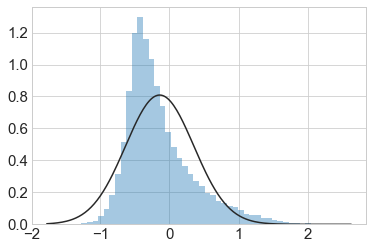

In [11]:
import seaborn as sns
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

sns.set_style("whitegrid")
sns.distplot(psycho_embeddings[:, 0], kde=False, fit=scipy.stats.norm)
plt.show()

In [12]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def find_optimal_num_pca_components(X_mat, min_num_components, max_num_components, interval):
    """Find optimal # of PCA components via cross-validation
    
    Args:
        X_mat: The data matrix, num obs rows with num vars columns
        min_num_components: The minimum number of components to try
        max_num_components: The maximum number of components to try
    
    Returns:
        n_components_pca: The optimal number of components under cross-validation
    """
    n_components = np.arange(min_num_components, max_num_components, interval)
    
    def compute_scores(X):
        pca = PCA(svd_solver='full')
        pca_scores = []
        for n in n_components:
            # Print a few times (5 in this case) during the process of finding PCA components
            if n % 10 == 0:
                print("Running dimensionality reduction for {} components...".format(n))
            pca.n_components = n
            pca_scores.append(np.mean(cross_val_score(pca, X)))
        return pca_scores
    
    # 'compute_scores' Calculates average log-likelihood over all validation-fold samples
    # using Probabilistic Principal Component Analysis model given by 
    # M. Tipping and C. Bishop, Probabilistic Principal Component Analysis, 
    # Journal of the Royal Statistical Society
    pca_cv_scores = compute_scores(X_mat)
    n_components_pca = n_components[np.argmax(pca_cv_scores)]
    print("best n_components by PCA CV = %d" % n_components_pca)
    return n_components_pca, n_components, pca_cv_scores

def plot_pca_scores(best_n_components, n_components_seq, pca_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_components_seq, pca_scores, 'b', label='PCA scores')
    plt.axvline(best_n_components, color='b',
                label='Optimal No. PCs: %d' % best_n_components, linestyle='--')
    plt.xlabel('Number of Principal Components', fontsize=20)
    plt.ylabel('Log-Likelihood on Validation Fold', fontsize=20)
    legend = plt.legend(loc='lower right')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Components in PCA\n' + \
              'via Log-Likelihood with Cross-Validation', fontsize=20)
    plt.show()

In [16]:
psycho_best_n_pca_comps = 96
# psycho_best_n_pca_comps, n_components_seq, pca_cv_scores = find_optimal_num_pca_components(psycho_embeddings, 
#                                                                                            85, 102, 1)
# plot_pca_scores(psycho_best_n_pca_comps, n_components_seq, pca_cv_scores)

In [17]:
# embeddings_pca = PCA(n_components=best_n_pca_comps)
# embeddings_pca.fit(embeddings)
# embeddings_pca_scores = embeddings_pca.transform(embeddings)
psycho_embeddings_pca = PCA(n_components=psycho_best_n_pca_comps)
psycho_embeddings_pca.fit(psycho_embeddings)
psycho_embeddings_pca_scores = psycho_embeddings_pca.transform(psycho_embeddings)
# psycho_embeddings_pca.fit(psycho_embeddings_no_dep)
psycho_embeddings_pca_no_dep_scores = psycho_embeddings_pca.transform(psycho_embeddings_no_dep)

In [18]:
color_map = plt.cm.get_cmap(name='tab10', lut=None).colors

In [19]:
# NOTE: Running this code takes a LONG TIME!!! (33,996 samples took ~20 minutes on my local machine)
# from sklearn.manifold import TSNE
# embeddings_tsne = TSNE(n_components=2, verbose=1)
# embeddings_tsne_scores = embeddings_tsne.fit_transform(psycho_embeddings_pca_scores)

In [20]:
# np.save('emotype_tsne_embeddings_v10_all.npy', embeddings_tsne_scores)
# np.save('emotype_original_labels_v10_all.py', psycho_labels)
embeddings_tsne_scores = np.load('emotype_tsne_embeddings_v10_all.npy')
psycho_labels = np.load('emotype_original_labels_v10_all.py.npy')

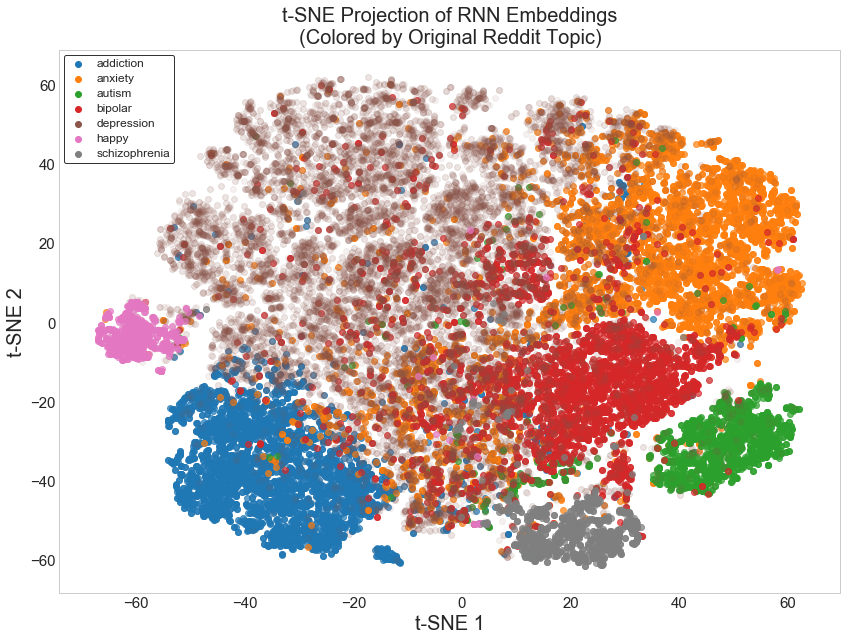

In [21]:
np.unique(psycho_labels)
fig, ax = plt.subplots(figsize=(14,10))
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)

plt.title('t-SNE Projection of RNN Embeddings\n' + \
           '(Colored by Original Reddit Topic)', fontsize=20)
for y in np.unique(psycho_labels):
#     if y == 'conversation' or y =='depression':
#         continue
    tmp_alpha = 0.7
    if y == 'depression':
        tmp_alpha = 0.08
    ax.scatter(embeddings_tsne_scores[psycho_labels == y, 0],
               embeddings_tsne_scores[psycho_labels == y, 1], 
               label = y,
               color = color_map[label_cluster_dict[y]],
               alpha = tmp_alpha,
               cmap='tab10')
ax.grid(False)
legend = plt.legend(loc='lower right')
legend = plt.legend(frameon = 1)
for txt in legend.get_texts():
    txt.set_size('large')
for lh in legend.legendHandles: 
    lh.set_alpha(1)  # https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.setp(frame.get_texts(), fontsize='12')
plt.show()

In [25]:
n_clusters = 5
from sklearn.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(init='k-means++', 
                           n_clusters=n_clusters, 
                           batch_size=1000,
                           n_init=10,
                           max_no_improvement=20,
                           random_state=42, # What's the meaning of life?
                           verbose=1)
tmp_cluster_labels = clusterer.fit_predict(psycho_embeddings_pca_scores)

Init 1/10 with method: k-means++
Inertia for init 1/10: 25176.464188
Init 2/10 with method: k-means++
Inertia for init 2/10: 23215.375386
Init 3/10 with method: k-means++
Inertia for init 3/10: 24391.701414
Init 4/10 with method: k-means++
Inertia for init 4/10: 23311.703619
Init 5/10 with method: k-means++
Inertia for init 5/10: 23038.647154
Init 6/10 with method: k-means++
Inertia for init 6/10: 24758.856487
Init 7/10 with method: k-means++
Inertia for init 7/10: 25333.954170
Init 8/10 with method: k-means++
Inertia for init 8/10: 26864.571327
Init 9/10 with method: k-means++
Inertia for init 9/10: 23413.215378
Init 10/10 with method: k-means++
Inertia for init 10/10: 22791.887775
Minibatch iteration 1/4300: mean batch inertia: 7.525299, ewa inertia: 7.525299 
Minibatch iteration 2/4300: mean batch inertia: 7.518267, ewa inertia: 7.524971 
Minibatch iteration 3/4300: mean batch inertia: 7.447503, ewa inertia: 7.521358 
Minibatch iteration 4/4300: mean batch inertia: 7.531059, ewa ine

In [43]:
from sklearn.metrics import silhouette_score
N = tmp_cluster_labels.shape[0]
n = 10000
sample_indices = np.random.choice(N, n, replace=False)
sample_silhouette_avg = silhouette_score(psycho_embeddings_pca_scores[sample_indices, :], 
                                         tmp_cluster_labels[sample_indices])

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# n_optimal_clusters_kmeans, n_components_seq, sil_scores

def find_optimal_num_clusters_kmeans(X, min_num_clusters=2, max_num_clusters=12):
    n_components_seq = range(min_num_clusters, max_num_clusters)
    n_optimal_clusters_kmeans = 0
    silhouette_scores = []
    best_cluster_labels = []
    best_sil_score = -np.infty
    for n_clusters in n_components_seq:
        print('Running K-Means for {} Clusters...'.format(n_clusters))
        clusterer = KMeans(init='k-means++', 
                           n_clusters=n_clusters, 
                           batch_size=1000,
                           n_init=10,
                           max_no_improvement=20,
                           random_state=42, # What's the meaning of life?
                           verbose=1)
        tmp_cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, tmp_cluster_labels)
        if silhouette_avg > best_sil_score:
            best_sil_score = silhouette_avg
            best_cluster_labels = tmp_cluster_labels
            n_optimal_clusters_kmeans = n_clusters
        silhouette_scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "the average silhouette_score is :", silhouette_avg)
    return n_optimal_clusters_kmeans, best_cluster_labels, n_components_seq, silhouette_scores

In [22]:
n_kmeans, cluster_labels, n_comps_seq, sil_scores = find_optimal_num_clusters_kmeans(psycho_embeddings_pca_scores)

Running K-Means for 2 Clusters...


KeyboardInterrupt: 

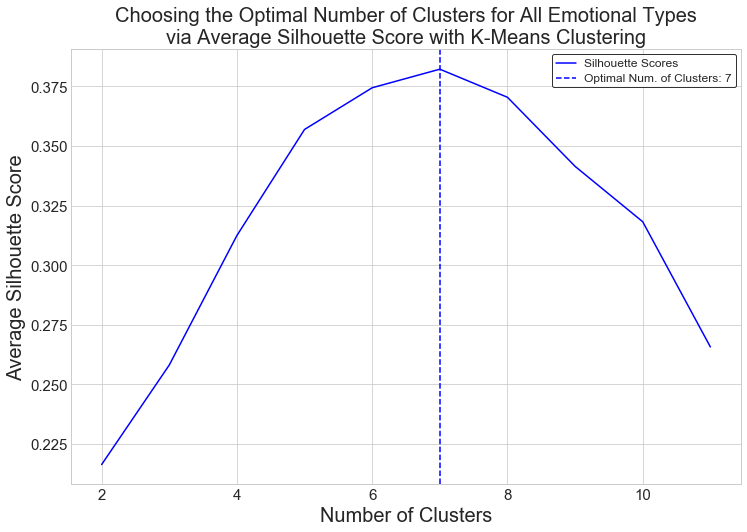

In [102]:
def plot_silhouette_scores(best_n_clusters, n_comps_seq, sil_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_comps_seq, sil_scores, 'b', label='Silhouette Scores')
    plt.axvline(best_n_clusters, color='b',
                label='Optimal Num. of Clusters: %d' % best_n_clusters, linestyle='--')
    plt.xlabel('Number of Clusters', fontsize=20)
    plt.ylabel('Average Silhouette Score', fontsize=20)
    legend = plt.legend(loc='best')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Clusters for All Emotional Types\n' + \
              'via Average Silhouette Score with K-Means Clustering', fontsize=20)
    plt.show()
    
plot_silhouette_scores(n_kmeans, n_comps_seq, sil_scores)

In [105]:
print(cluster_labels.shape, cluster_labels)

(700,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 3 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 4 6 1 6 6 6 1 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 6 1 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6
 6 6 6 6 3 3 1 1 3 5 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 1 3 3 3 1 3 3 3 1
 3 3 3 1 3 3 3 3 1 3 1 3 3 1 3 3 3 3 3 3 1 3 3 3 3 3 3 1 3 3 1 3 1 3 3 3 1
 3 3 3 3 3 1 1 3 3 3 4 3 3 3 3 3 1 3 3 0 3 3 3 3 1 3 4 3 3 3 1 1 1 1 1 1 1
 1 1 1 1 4 1 1 1 1 1 1 2 1 1 3 1 1 5 0 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 4 3 1
 1 1 1 4 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1